# Helpers

## Data models

In [1]:
from typing import List
from typing import Callable
from typing import Tuple

class Rectangle:
    
    def __init__(self, width=0, height=0, x=0, y=0, ident=1):
        self.width = width
        self.height = height
        self.x = x
        self.y = y
        self.ident = ident
        self.centerX = x+width/2
        self.centerY = y+height/2
    
    def __str__(self):
        return f'{self.ident}: ({self.width},{self.height},{self.x},{self.y}) whxy'
    
    def checkOverlap(self, other):
        """
        Check if two Rectangle objects overlap.
        Return True if they overlap, False otherwise.
        """
        x_overlap = max(0, min(self.x + self.width, other.x + other.width) - max(self.x, other.x))
        y_overlap = max(0, min(self.y + self.height, other.y + other.height) - max(self.y, other.y))
        overlap_area = x_overlap * y_overlap
        return overlap_area > 0
    
def decodeIntList(lst: List[str]) -> List[int]:
    return list(map(int, lst))

def decodeFloatList(lst: List[str]) -> List[float]:
    return list(map(float, lst))

def decodeRectangles(lst: List[str], idents: List[str]) -> List[Rectangle]:
    return list(map(decodeRectangle, *(lst,idents)))

def decodeRectangle(rec: str, ident: str) -> Rectangle:
    x,y,w,h = rec.split(',')
    return Rectangle(x=int(x), y=int(y), width=int(w), height=int(h), ident=ident)


class Individual:
    def __init__(self, iteration: int, objectiveValue: int, paintingSeq: List[int], paintingSeqDecoded: List[int], paintingSeqRandomKey: List[float], slicingOrderDecoded: List[int], slicingOrderRandomKey: List[float], orientations: List[str], orientationsCapped: List[str], orientationsResolved: List[str], paintingAllocatedSpace: List[Rectangle], paintingPlacement: List[Rectangle]):
        self.iteration = iteration
        self.objectiveValue = objectiveValue
        self.paintingSeq = paintingSeq
        self.paintingSeqDecoded = paintingSeqDecoded
        self.paintingSeqRandomKey = paintingSeqRandomKey
        self.slicingOrderDecoded = slicingOrderDecoded
        self.slicingOrderRandomKey = slicingOrderRandomKey
        self.orientations = orientations
        self.orientationsCapped = orientationsCapped
        self.orientationsResolved = orientationsResolved
        self.paintingAllocatedSpace = paintingAllocatedSpace
        self.paintingPlacement = paintingPlacement
        
    @staticmethod
    def create(json: dict) -> 'Individual':
        return Individual(
            iteration=int(json['iteration']),
            objectiveValue=float(json['objectiveValue']),
            paintingSeq=json['paintingSeq'],
            paintingSeqDecoded=json['paintingSeqDecoded'],
            paintingSeqRandomKey=decodeFloatList(json['paintingSeqRandomKey']),
            slicingOrderDecoded=decodeIntList(json['slicingOrderDecoded']),
            slicingOrderRandomKey=decodeFloatList(json['slicingOrderRandomKey']),
            orientations=json['orientations'],
            orientationsCapped=json['orientationsCapped'],
            orientationsResolved=json['orientations'], # TODO provide resolved orientations
            paintingAllocatedSpace=decodeRectangles(json['paintingAllocatedSpace_XYWH'], json['paintingSeqDecoded']),
            paintingPlacement=decodeRectangles(json['paintingPlacement_XYWH'], json['paintingSeqDecoded']))
    
class Painting:
    def __init__(self, ident: str, width: int, height: int):
        self.ident = ident
        self.width = width
        self.height = height
        
    @staticmethod
    def create(json: dict) -> 'Painting':
        return Painting(
            ident=json['ident'],
            width=int(json['width']),
            height=int(json['height']))
    
class HallOfFameRecord:
    def __init__(self, iteration: int, objectiveMin: float, objectiveMax: float, objectiveAvg: float, bestIndividual: Individual):
        self.iteration = iteration
        self.objectiveMin = objectiveMin
        self.objectiveMax = objectiveMax
        self.objectiveAvg = objectiveAvg
        self.bestIndividual = bestIndividual
    
    @staticmethod
    def create(json: dict) -> 'HallOfFameRecord':
        return HallOfFameRecord(
            iteration=int(json['iteration']),
            objectiveMin=float(json['objectiveMin']),
            objectiveMax=float(json['objectiveMax']),
            objectiveAvg=float(json['objectiveAvg']),
            bestIndividual=Individual.create(json['bestIndividual']))
            
class GaResult:
    def __init__(self, bestIndividual: Individual, hallOfFame: List[HallOfFameRecord]):
        self.bestIndividual = bestIndividual
        self.hallOfFame = hallOfFame
        
    @staticmethod
    def create(json: dict) -> 'GaResult':
        return GaResult(
            bestIndividual=Individual.create(json['bestIndividual']),
            hallOfFame=list(map(HallOfFameRecord.create, json['hallOfFame']['records'])))

class GaParameters:
    def __init__(self, maxNumberOfIter: int, populationSize: int, maximumWildCardCount: int, geneticAlgorithm: str, orientationWeights: List, populationDivisionCounts: dict, initialPopulationDivisionCounts: dict, mate: str, mutate: str, select: str):
        self.maxNumberOfIter = maxNumberOfIter
        self.populationSize = populationSize
        self.maximumWildCardCount = maximumWildCardCount
        self.geneticAlgorithm = geneticAlgorithm
        self.orientationWeights = orientationWeights
        self.populationDivisionCounts = populationDivisionCounts
        self.initialPopulationDivisionCounts = initialPopulationDivisionCounts
        self.mate = mate
        self.mutate = mutate
        self.select = select
        
    @staticmethod
    def create(json: dict) -> 'GaParameters':
        return GaParameters(
            maxNumberOfIter=int(json['maxNumberOfIter']),
            populationSize=int(json['populationSize']),
            maximumWildCardCount=int(json['maximumWildCardCount']),
            geneticAlgorithm=json['geneticAlgorithm'],
            orientationWeights=json['orientationWeights'],
            populationDivisionCounts=json['populationDivisionCounts'],
            initialPopulationDivisionCounts=json['initialPopulationDivisionCounts'],
            mate=json['mate'],
            mutate=json['mutate'],
            select=json['select'])

class Layout:
    def __init__(self, width: int, height: int, evalFunc: str):
        self.width = width
        self.height = height
        self.evalFunc = evalFunc
        self.boundingRectangle = Rectangle(width=width, height=height, x=0, y=0, ident="")
        
    @staticmethod
    def create(json: dict) -> 'Layout':
        return Layout(width=json['width'], height=json['height'], evalFunc=json['evalFunc'])
    
class Flow:
    def __init__(self, src: int, dst: int, flow: float):
        self.src = src
        self.dst = dst
        self.flow = flow
        
    @staticmethod
    def create(json: dict) -> 'Flow':
        return Flow(
            src=int(json['from']),
            dst=int(json['to']),
            flow=float(json['flow']))
    
class InstanceParameters:
    def __init__(self, layout: Layout, paintings: List[Painting], paintingsFlow: List[Flow]):
        self.layout = layout
        self.paintings = paintings
        self.paintingsFlow = paintingsFlow
        
    @staticmethod
    def create(json: dict) -> 'InstanceParameters':
        return InstanceParameters(
            layout=Layout.create(json['layout']),
            paintings=list(map(Painting.create, json['paintings'])),
            paintingsFlow=list(map(Flow.create, json['paintingsFlow'])))
    
class ObjectiveParameters:
    def __init__(self, name: str, params: dict):
        self.name = name
        self.params = params
        self.overlappingPenalizationConstant = params['overlappingPenalizationConstant'] # hotfix
    
    def __getattr__(self, name):
        if name in self.params:
            return self.params[name]
        raise AttributeError(f"'{type(self).__name__}' object has no attribute '{name}'")

        
    @staticmethod
    def create(json: dict) -> 'ObjectiveParameters':
        return ObjectiveParameters(
            name=json['name'],
            params=json['params'])
        

class ComputationResult:
    def __init__(self, applicationVersion: str, createdAt: str, durationMillis: int, gaResult: GaResult, gaParameters: GaParameters, instanceParameters: InstanceParameters, objectiveParameters: ObjectiveParameters, name: str = None):
        self.applicationVersion = applicationVersion
        self.createdAt = createdAt
        self.durationMillis = durationMillis
        self.gaResult = gaResult
        self.gaParameters = gaParameters
        self.instanceParameters = instanceParameters
        self.objectiveParameters = objectiveParameters
        self.name = name
        
    @staticmethod
    def createWithName(name: str, json: dict):
        compRes = ComputationResult.create(json)
        compRes.name = name
        return compRes
    
    @staticmethod
    def create(json: dict) -> 'ComputationResult':
        return ComputationResult(
            applicationVersion=json['applicationVersion'],
            createdAt=json['createdAt'],
            durationMillis=int(json['durationMillis']),
            gaResult=GaResult.create(json['gaResult']),
            gaParameters=GaParameters.create(json['gaParameters']),
            instanceParameters=InstanceParameters.create(json['instanceParameters']),
            objectiveParameters=ObjectiveParameters.create(json['objectiveParameters']))
    
class Dataset:
    def __init__(self, name: str, instanceParameters: InstanceParameters):
        self.name = name
        self.instanceParameters = instanceParameters
        self.data = instanceParameters
        
    @staticmethod
    def create(json: dict) -> 'Dataset':
        return Dataset(
            name=json['name'],
            instanceParameters=InstanceParameters.create(json['data']))

## Utils

In [32]:
from pathlib import Path
import json
import glob
import os
import fnmatch
import pandas as pd
import numpy as np
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm as CM

def _getDirPrefix(name: str) -> int:
    return int(name.split('_')[0])

def loadComputationResult(path: str, compResultFileName='computation_result.json', log=False) -> ComputationResult:
    if log:
        print(f'loading: {path}')
    with open(path + '/' + compResultFileName, 'r') as f:
        data = json.load(f)
    return ComputationResult.createWithName(path.split('/')[-1], data)

def loadLatestComputationResult(resultDir='/home/slarty/Documents/master-thesis/src/impl/out') -> ComputationResult:
    dirs = [x for x in Path(resultDir).iterdir() if x.is_dir()]
    latest, prefix = dirs[0], _getDirPrefix(dirs[0].name)
    for d in dirs:
        k = _getDirPrefix(d.name)
        if k > prefix:
            latest, prefix = d, k
    return loadComputationResult(str(latest.resolve()))

def findDirectoriesWithFile(startingDir, fileNameToSearch='computation_result.json'):
    # Use glob to find all directories that contain the file
    directories = glob.glob(os.path.join(startingDir, f'**/{fileNameToSearch}'), recursive=True)
    return [os.path.dirname(path) for path in directories]

def loadComputationResultBatch(startingDir, addName=False, addInstanceSize=False) -> List[ComputationResult]:
    def _addName(compRes, dirPath):
        compRes.name = os.path.basename(dirPath).rsplit('_',1)[0].split('_', 1)[1] # magic
        compRes.path = dirPath
    
    def _addInstanceSize(compRes):
        compRes.size = len(compRes.instanceParameters.paintings)
    
    def _applyHooks(compRes, dirPath):
        if addName:
            _addName(compRes, dirPath)
        if addInstanceSize:
            _addInstanceSize(compRes)
        return compRes
            
    return [ _applyHooks(loadComputationResult(d),d) for d in findDirectoriesWithFile(startingDir)]

def findDatasetPath(name, datasetDir='../datasets') -> str:
    for root, dirs, files in os.walk(datasetDir):
        for filename in fnmatch.filter(files, f"{name}.json"):
            return os.path.join(root, filename)
    raise FileNotFoundError(f"No file found with name {name}.json in directory {datasetDir}")

def loadDataset(name, datasetDir='/home/slarty/Documents/master-thesis/src/impl/public/datasets') -> Dataset:
    path = findDatasetPath(name, datasetDir)
    print(f'Loading {path}')
    with open(path, 'r') as f:
        data = json.load(f)
    return Dataset.create(data)

def findFileInDirectory(directory, filename):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file == filename:
                return os.path.join(root, file)
    return None

def compResToDf(compResLst: List[ComputationResult]) -> pd.DataFrame:
    def getAttrNested(obj, name, sp='.'):
        # print(name, obj.path)
        val = obj
        for attr in name.split(sp):
            val = getattr(val, attr)
        return val
            
    colsLong =['name',
           'gaResult.bestIndividual.iteration',
           'gaResult.bestIndividual.objectiveValue',
           'durationMillis',
           'gaParameters.maxNumberOfIter',
           'gaParameters.populationSize',
           'gaParameters.maximumWildCardCount',
           'gaParameters.orientationWeights',
           'gaParameters.populationDivisionCounts',
           'gaParameters.initialPopulationDivisionCounts',
           'instanceParameters.layout.width',
           'instanceParameters.layout.height',
           'objectiveParameters.overlappingPenalizationConstant',
           'objectiveParameters.outsideOfAllocatedAreaPenalizationConstant',
           'size',
              ] 
    data = []
    for compRes in compResLst:
        record = []
        record.extend([getAttrNested(compRes, name) for name in colsLong])
        record.append(np.array([x.objectiveAvg for x in compRes.gaResult.hallOfFame]))
        record.append(np.array([x.bestIndividual.paintingPlacement for x in compRes.gaResult.hallOfFame]))
        record.append(np.array([x.bestIndividual.paintingAllocatedSpace for x in compRes.gaResult.hallOfFame]))
        record.append(np.array([x.bestIndividual.orientations for x in compRes.gaResult.hallOfFame]))
        data.append(record)
    return pd.DataFrame(data, columns=map(lambda x: x.split('.')[-1], colsLong+['avgObjTS', 'paintingPlacement', 'paintingAllocatedSpace', 'orientations']))

def findFileInDirectory(directory, filename):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file == filename:
                return os.path.join(root, file)
    return None

##########
# PLOTTING
##########

def smooth(x, y, k=3):
    """ Just for nice smooth graphs """
    from scipy.interpolate import make_interp_spline, BSpline
    # 300 represents number of points to make between T.min and T.max
    xnew = np.linspace(min(x), max(x), 300) 

    spl = make_interp_spline(x, y, k)  # type: BSpline
    power_smooth = spl(xnew)
    
    return xnew, power_smooth

def addGridToFigure():
    plt.rc('axes', axisbelow=True)
    plt.grid(True)

def improve_legend(delta, right_most_x):
    ax = plt.gca()
    for spine in ax.spines:
        ax.spines[spine].set_visible(False)
        
    groups = dict()
    
    for line in ax.lines:
        data_x, data_y = line.get_data()
        right_most_y = data_y[-1]
        added = False
        for k,v in groups.items():
            if np.abs(k-right_most_y) < delta:
                v.append(line)
                added = True
                break
        if not added:
            groups[right_most_y] = [line]
            
        for right_most_y, line_lst in groups.items():
            text = ', '.join(x.get_label() for x in line_lst)
            ann = ax.annotate(text, xy=(right_most_x, right_most_y), fontsize=8)
        
def plotter(x, y, label, title, legendTitle, ncol=1, scatterDotSize=2,linewidth=1, fontsize=10,
           xlabel='', ylabel='', figsize=None, annotateEndOfLines=False, annotateEndOfLinesPenalization=40,
           linestyle='solid'):
    turnSpinesOff()
    plt.rcParams.update({'font.size': 9})
    
    plt.plot(*smooth(x,y), label=label,linewidth=linewidth, linestyle=linestyle)
    plt.scatter(x, y, s=scatterDotSize)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    addGridToFigure()
    
    
    if annotateEndOfLines:
        ymin, ymax = plt.ylim()
        xmin, xmax = plt.xlim()
        delta = ymax/annotateEndOfLinesPenalization
        improve_legend(delta=delta, right_most_x=xmax)
    
    if legendTitle is not None and len(legendTitle) > 0:
        lgd = plt.legend(title=legendTitle, fontsize=fontsize, ncol=ncol)
        
def turnSpinesOff():
    mpl.rcParams['axes.spines.left'] = False
    mpl.rcParams['axes.spines.right'] = False
    mpl.rcParams['axes.spines.top'] = False
    mpl.rcParams['axes.spines.bottom'] = False
    
def turnSpinesOn():
    mpl.rcParams['axes.spines.left'] = True
    mpl.rcParams['axes.spines.right'] = True
    mpl.rcParams['axes.spines.top'] = True
    mpl.rcParams['axes.spines.bottom'] = True

# Copy to thesis figures

In [77]:
import os
import shutil

sourceDir = './figures2'
destDir = '/home/slarty/Documents/master-thesis/src/thesis/figures/hyperparameters'

for filename in os.listdir(sourceDir):
    if filename.endswith('.pdf'):
        shutil.copy(os.path.join(sourceDir, filename), destDir)

# Hyperparameters

## 1. Max number of iter

In [162]:
r = loadComputationResultBatch('./out_hyperparameters/max_number_of_iter', addName=True, addInstanceSize=True)
dfIter = compResToDf(r)
dfIter = dfIter[dfIter.maxNumberOfIter == 1000]

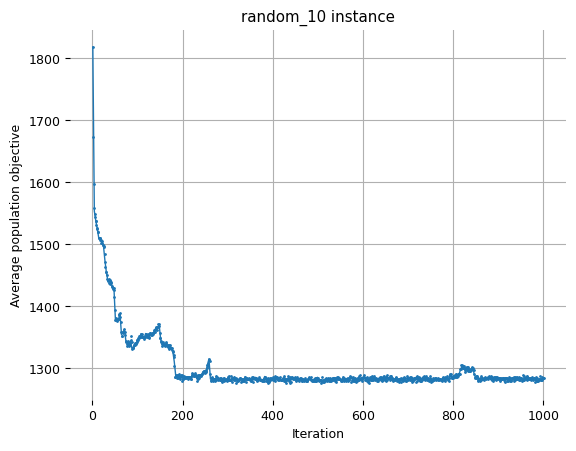

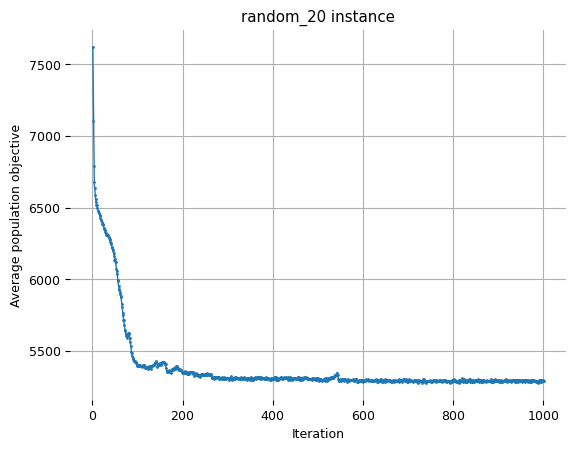

In [163]:
# zprumerovat nekoklik behu s maxNumberOfIter=500 pro random_10 a random_20
turnSpinesOff()
plt.rcParams.update({'font.size': 9})
dfIterTS = dfIter.groupby([dfIter.name, dfIter.maxNumberOfIter])['avgObjTS'].mean()

for name in dfIter.name.unique():
    for maxNumberOfIter in dfIter[dfIter.name == name].maxNumberOfIter.unique():
        label = f'label'
        ts = dfIterTS[name, maxNumberOfIter]
        plotter(x=range(1, len(ts)+1), y=ts, label=None, title=f'{name} instance', legendTitle=None, scatterDotSize=1, linewidth=1,
               fontsize=9, xlabel='Iteration', ylabel='Average population objective')
    plt.savefig(f'figures2/max_number_of_iter_{name}.pdf', bbox_inches='tight')
    plt.show()

## 2. Population size

In [25]:
r = loadComputationResultBatch('./out_hyperparameters/population_size', addName=True, addInstanceSize=True)
dfPopSize = compResToDf(r)
dfPopSize['populationScalingFactor'] = (dfPopSize.populationSize / dfPopSize['size']).astype('int32')
dfPopSize = dfPopSize[dfPopSize.populationScalingFactor.isin([10,50,100])]

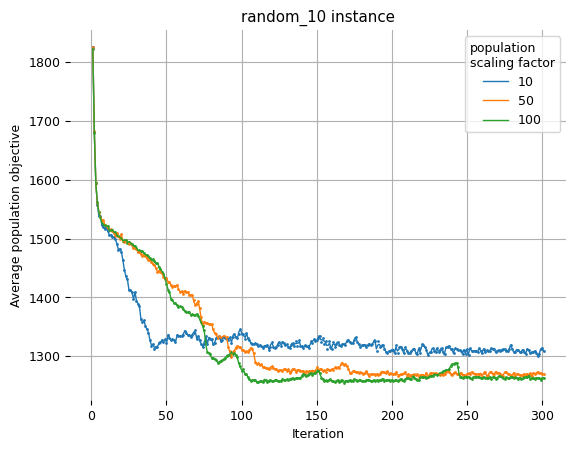

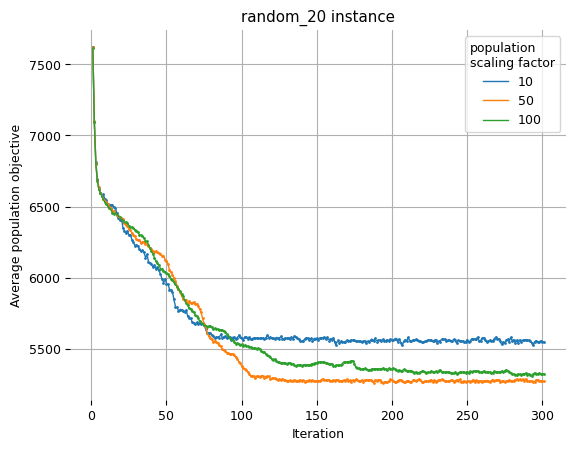

In [26]:
turnSpinesOff()
plt.rcParams.update({'font.size': 9})
dfPopSizeTS = dfPopSize.groupby([dfPopSize.name, dfPopSize.populationScalingFactor])['avgObjTS'].mean()

for name in dfPopSize.name.unique():
    for populationScalingFactor in dfPopSize.populationScalingFactor.unique():
        label = f'{populationScalingFactor}'
        ts = dfPopSizeTS[name, populationScalingFactor]
        plotter(x=range(1, len(ts)+1), y=ts, label=label, title=f'{name} instance', legendTitle='population\nscaling factor', scatterDotSize=1,
               fontsize=9, xlabel='Iteration', ylabel='Average population objective')
    plt.savefig(f'figures2/population_size_{name}.pdf', bbox_inches='tight')
    plt.show()

## 3. Maximum wild card count

In [159]:
r = loadComputationResultBatch('./out_hyperparameters/maximum_wild_card_count', addName=True, addInstanceSize=True)
dfWild = compResToDf(r)
dfWild['durationSeconds'] = dfWild.durationMillis / 1000
dfWild['durationMinutes'] = dfWild.durationSeconds / 60

### Copmutation speed

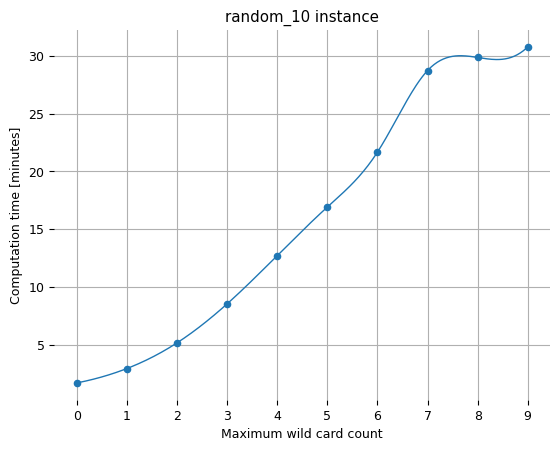

In [166]:
turnSpinesOff()
plt.rcParams.update({'font.size': 9})
dfWildTS = dfWild.groupby([dfWild.name, dfWild.maximumWildCardCount])['durationMinutes'].mean()

for name in dfWild.name.unique():
    tmp = dfWildTS[name].reset_index()[['maximumWildCardCount', 'durationMinutes']]
    x = tmp['maximumWildCardCount'].tolist()
    y = tmp['durationMinutes'].tolist()
    plotter(x=x, y=y, label=None, title=f'{name} instance', legendTitle='', scatterDotSize=20,
           fontsize=9, xlabel='Maximum wild card count', ylabel='Computation time [minutes]', ncol=1)
    plt.savefig(f'figures2/maximum_wild_card_count_computation_time_{name}.pdf', bbox_inches='tight')
    plt.xticks(x)
    plt.show()

### Objective

In [65]:
turnSpinesOff()
plt.rcParams.update({'font.size': 9})
dfWildTS = dfWild.groupby([dfWild.name, dfWild.maximumWildCardCount])['avgObjTS'].mean()

for name in dfWild.name.unique():
    plt.figure(figsize=(10,7))
    for maximumWildCardCount in dfWild.maximumWildCardCount.unique():
        ts = dfWildTS[name, maximumWildCardCount]
        plotter(x=range(1, len(ts)+1)[:300], y=ts[:300], label=maximumWildCardCount, title=f'{name} instance', legendTitle='maximumWildCardCount', scatterDotSize=1,
               fontsize=9, xlabel='Iteration', ylabel='Average population objective', ncol=2, annotateEndOfLines=True)
    plt.savefig(f'figures2/maximum_wild_card_count_performance_{name}.pdf', bbox_inches='tight')
    plt.show()

NameError: name 'dfWild' is not defined

## 4. Orientation weights

In [70]:
r = loadComputationResultBatch('./out_hyperparameters/orientation_weights', addName=True, addInstanceSize=True)
dfWeights = compResToDf(r)
dfWeights['orientationWeightWildcard'] = dfWeights.orientationWeights.apply(lambda x: x[-1])
dfWeights['wildCardCount'] =  dfWeights.orientations.apply(lambda listOfLists: np.array([dict(zip(*np.unique(x, return_counts=True))).get('*',0) for x in listOfLists]))

### Performance

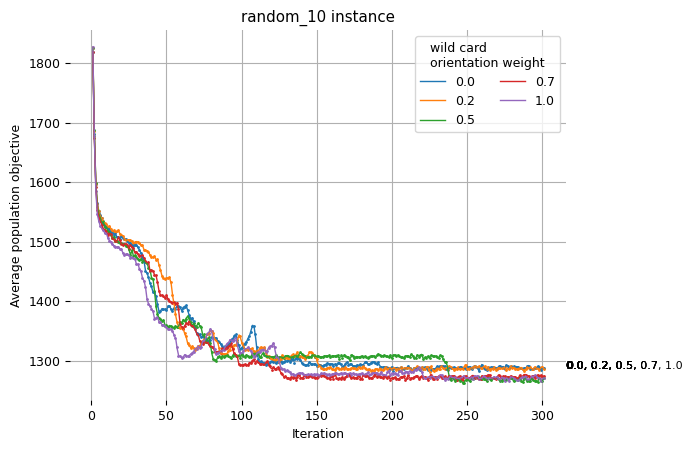

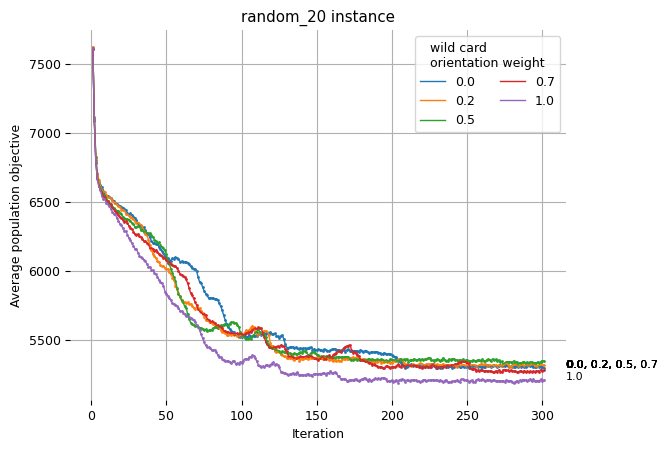

In [66]:
dfWeightsTS = dfWeights.groupby([dfWeights.name, dfWeights.orientationWeightWildcard])['avgObjTS'].mean()

for name in dfWeights.name.unique():
    # plt.figure(figsize=(10,7))
    for orientationWeightWildcard in dfWeights.orientationWeightWildcard.unique():
        ts = dfWeightsTS[name, orientationWeightWildcard]
        plotter(x=range(1, len(ts)+1), y=ts, label=orientationWeightWildcard, title=f'{name} instance', legendTitle='wild card\norientation weight', scatterDotSize=1,
               fontsize=9, xlabel='Iteration', ylabel='Average population objective', ncol=2, annotateEndOfLines=True,annotateEndOfLinesPenalization=100)
    plt.savefig(f'figures2/orientation_weights_{name}.pdf', bbox_inches='tight')
    plt.show()

### Wildcard cut type spread

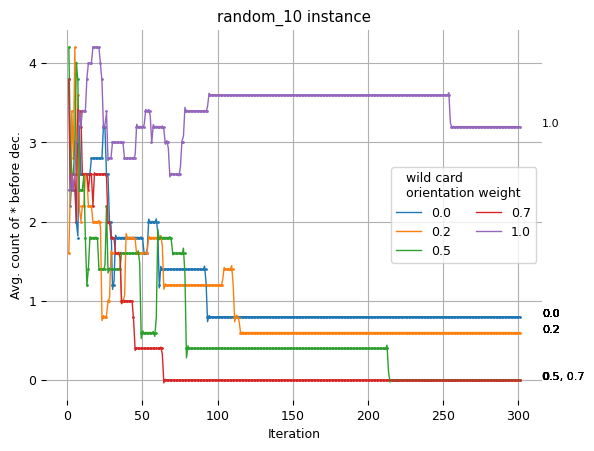

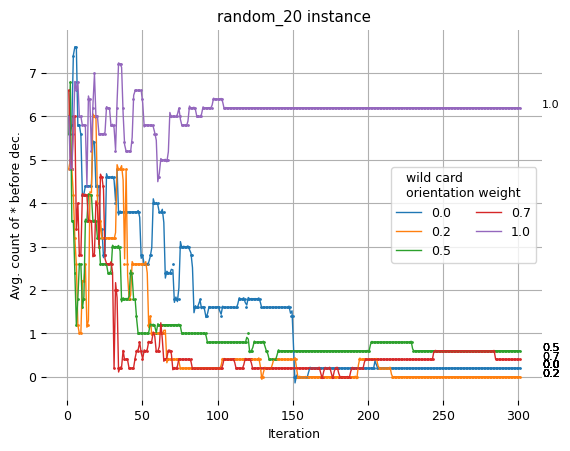

In [76]:
dfWeightsTS = dfWeights.groupby([dfWeights.name, dfWeights.orientationWeightWildcard])['wildCardCount'].mean()

for name in dfWeights.name.unique():
    # plt.figure(figsize=(10,7))
    for orientationWeightWildcard in dfWeights.orientationWeightWildcard.unique():
        ts = dfWeightsTS[name, orientationWeightWildcard]
        plotter(x=range(1, len(ts)+1), y=ts, label=orientationWeightWildcard, title=f'{name} instance', legendTitle='wild card\norientation weight', scatterDotSize=1,
               fontsize=9, xlabel='Iteration', ylabel='Avg. count of * before dec.', ncol=2, annotateEndOfLines=True,annotateEndOfLinesPenalization=100)
    plt.savefig(f'figures2/orientation_weights_wildcard_cut_type_spread_{name}.pdf', bbox_inches='tight')
    plt.show()

## 5. Population division counts

In [8]:
r = loadComputationResultBatch('./out_hyperparameters/population_division_counts', addName=True, addInstanceSize=True)
dfMaxNumberOfIter = compResToDf(loadComputationResultBatch('./out_hyperparameters/max_number_of_iter', addName=True, addInstanceSize=True))
dfCounts = compResToDf(r)
dfCounts['popRandom'] = dfCounts.populationDivisionCounts.apply(lambda x: x['random'])
dfCounts['popElite'] = dfCounts.populationDivisionCounts.apply(lambda x: x['elite'])

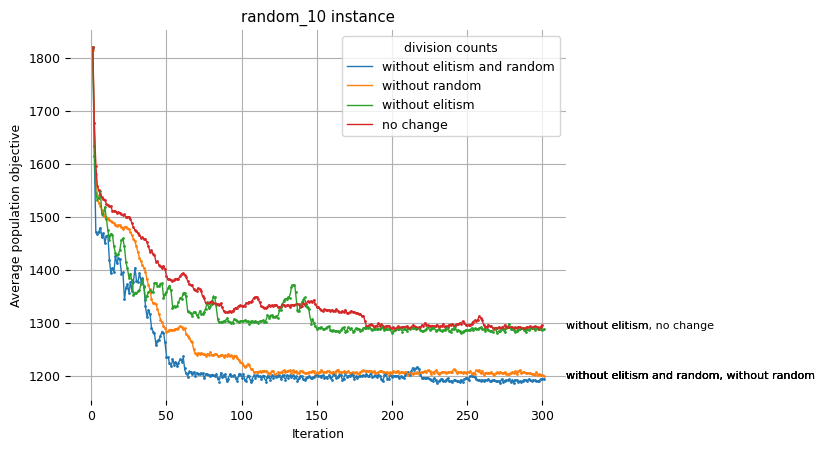

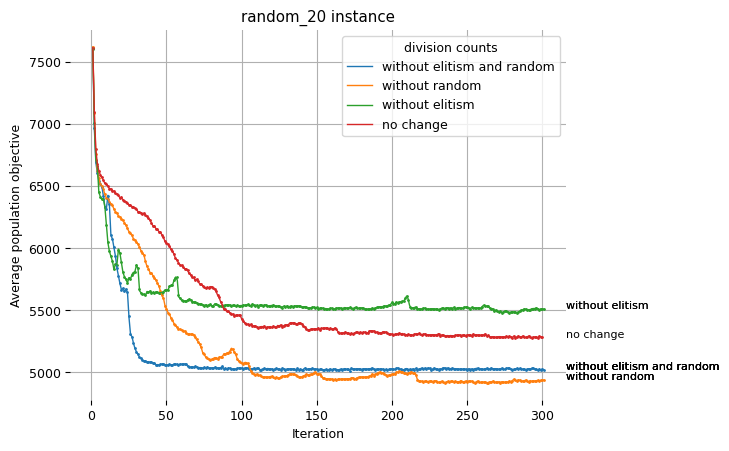

In [17]:
gb = dfCounts.groupby([dfCounts.name, dfCounts.popRandom, dfCounts.popElite])

def createLabel(random, elite):
    if random == 0 and elite == 0.2:
        return 'without random'
    if random == 0.1 and elite == 0.01:
        return 'without elitism'
    if random == 0 and elite == 0.01:
        return 'without elitism and random'
    raise ValueError(f"bad comparison, random={random}, elite={elite}")
    

for name in dfCounts.name.unique():
    gb = dfCounts[dfCounts.name==name].groupby([dfCounts.popRandom, dfCounts.popElite])
    tsGb = gb['avgObjTS'].mean()
    for random, elite in map(lambda x: x[0], gb.groups.items()):
        ts = tsGb[random, elite]
        plotter(x=range(1, len(ts)+1), y=ts, label=createLabel(random, elite), title=f'{name} instance', legendTitle='division counts', scatterDotSize=1,
               fontsize=9, xlabel='Iteration', ylabel='Average population objective', ncol=1)
    ts = dfMaxNumberOfIter[(dfMaxNumberOfIter.name == name) & (dfMaxNumberOfIter.maxNumberOfIter >= 300)]['avgObjTS'].map(lambda x: x[:300]).mean()
    annotateEndOfLinesPenalization = 200
    if (name == 'random_20'):
        annotateEndOfLinesPenalization = 300
        
    plotter(x=range(1, len(ts)+1), y=ts, label='no change', title=f'{name} instance', legendTitle='division counts', scatterDotSize=1,
           fontsize=9, xlabel='Iteration', ylabel='Average population objective', ncol=1, annotateEndOfLines=True,annotateEndOfLinesPenalization=annotateEndOfLinesPenalization)
    plt.savefig(f'figures2/population_division_counts_{name}.pdf', bbox_inches='tight')
    plt.show()

## 6. Initial population division counts

In [3]:
r = loadComputationResultBatch('./out_hyperparameters/initial_population_division_counts', addName=True, addInstanceSize=True)
dfInit = compResToDf(r)
dfInit['popInitRandom'] = dfInit.initialPopulationDivisionCounts.apply(lambda x: x['random'])

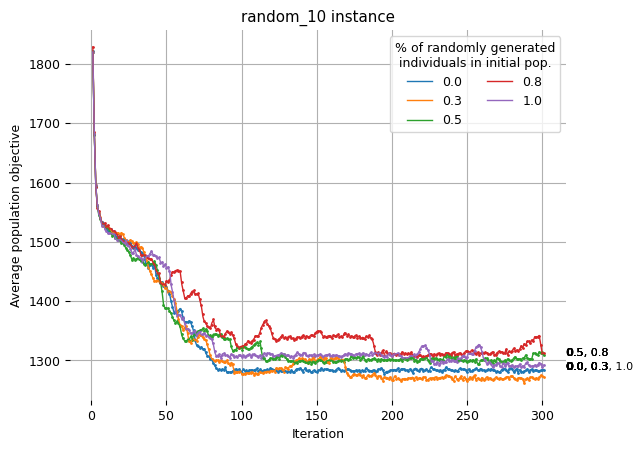

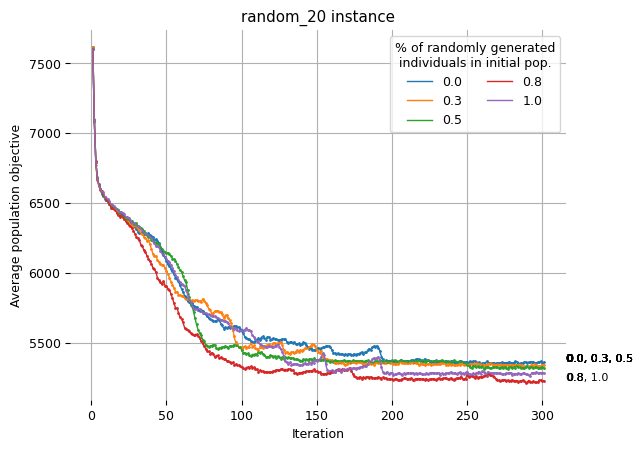

In [6]:
dfInitTS = dfInit.groupby([dfInit.name, dfInit.popInitRandom])['avgObjTS'].mean()

for name in dfInit.name.unique():
    for popInitRandom in dfInit.popInitRandom.unique():
        ts = dfInitTS[name, popInitRandom]
        plotter(x=range(1, len(ts)+1), y=ts, label=popInitRandom, title=f'{name} instance', legendTitle='% of randomly generated\n individuals in initial pop.', scatterDotSize=1,
               fontsize=9, xlabel='Iteration', ylabel='Average population objective', ncol=2, annotateEndOfLines=True,annotateEndOfLinesPenalization=130)
    plt.savefig(f'figures2/initial_population_division_counts_{name}.pdf', bbox_inches='tight')
    plt.show()

## 7. Overlapping penalization constant

In [21]:
def getOverlapCount(recLst: List[Rectangle]) -> int:
    cnt = 0
    for i in range(len(recLst)):
        for j in range(i+1, len(recLst)):
            if recLst[i].checkOverlap(recLst[j]):
                cnt += 1
    return cnt

r = loadComputationResultBatch('./out_hyperparameters/overlapping_penalization_constant', addName=True, addInstanceSize=True)
dfOverlap = compResToDf(r)
dfOverlap['overlapCnt'] = dfOverlap.paintingPlacement.apply(lambda xx: np.array([getOverlapCount(x) for x in xx]))
dfOverlap['overlappingMult'] =  (dfOverlap.overlappingPenalizationConstant / np.sqrt(dfOverlap.width**2+dfOverlap.height**2)).astype('float')

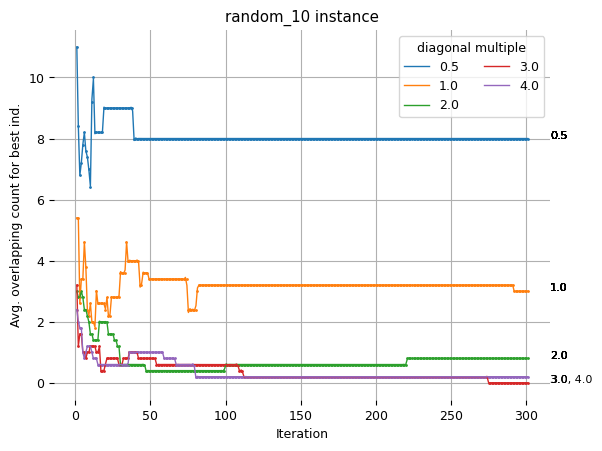

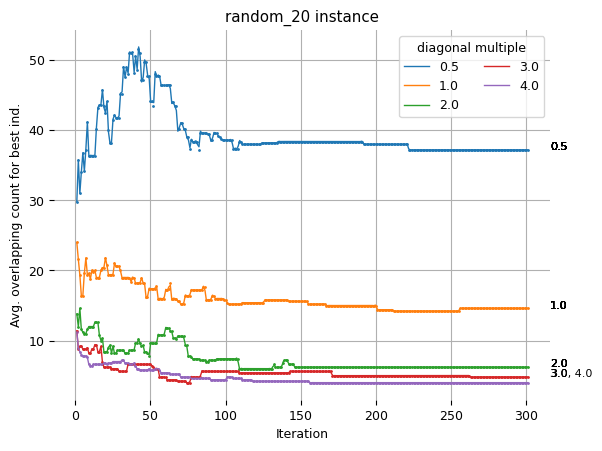

In [25]:
dfOverlapTS = dfOverlap.groupby(['name', 'overlappingMult'])['overlapCnt'].mean()

for name in dfOverlap.name.unique():
    for constant in dfOverlap.overlappingMult.unique():
        label = f'{constant}'
        ts = dfOverlapTS[name, constant]
        plotter(x=range(1, len(ts)+1), y=ts, label=label, title=f'{name} instance', legendTitle='diagonal multiple', scatterDotSize=1, ncol=2,
               fontsize=9, xlabel='Iteration', ylabel='Avg. overlapping count for best ind.',
               annotateEndOfLines=True,annotateEndOfLinesPenalization=50)
    plt.savefig(f'figures2/overlapping_penalization_constant_{name}.pdf', bbox_inches='tight')
    plt.show()

## 8. Outside of allocated area penalization constant

In [7]:
r = loadComputationResultBatch('./out_hyperparameters/outside_of_allocated_area_penalization_constant', addName=True, addInstanceSize=True)
dfAllocated = compResToDf(r)

In [14]:
def getOverlapCount(first: List[Rectangle], second: List[Rectangle]) -> int:
    cnt = 0
    for r1, r2 in zip(first, second):
        if r1.checkOverlap(r2):
            cnt += 1
    return cnt

r = loadComputationResultBatch('./out_hyperparameters/outside_of_allocated_area_penalization_constant', addName=True, addInstanceSize=True)
dfAllocated = compResToDf(r)
dfAllocated['overlapCnt'] = dfAllocated[['paintingPlacement', 'paintingAllocatedSpace']]\
        .apply(lambda x : np.array([getOverlapCount(a,b) for a,b in zip(x.paintingPlacement, x.paintingAllocatedSpace)]), axis=1)
dfAllocated['overlappingMult'] =  (dfAllocated.outsideOfAllocatedAreaPenalizationConstant / np.sqrt(dfAllocated.width**2+dfAllocated.height**2)).astype('float')

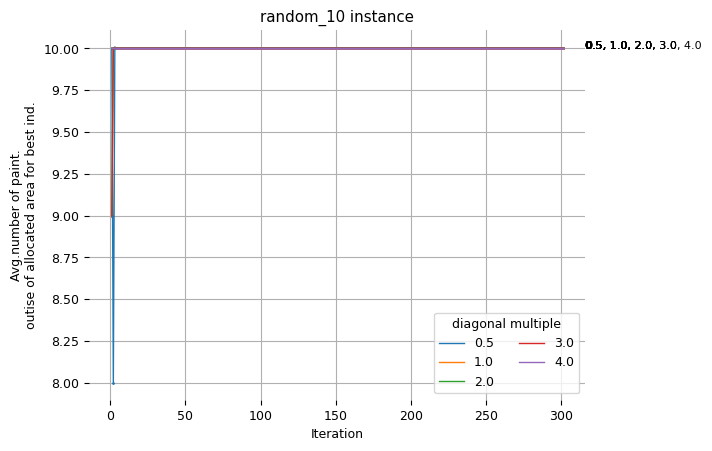

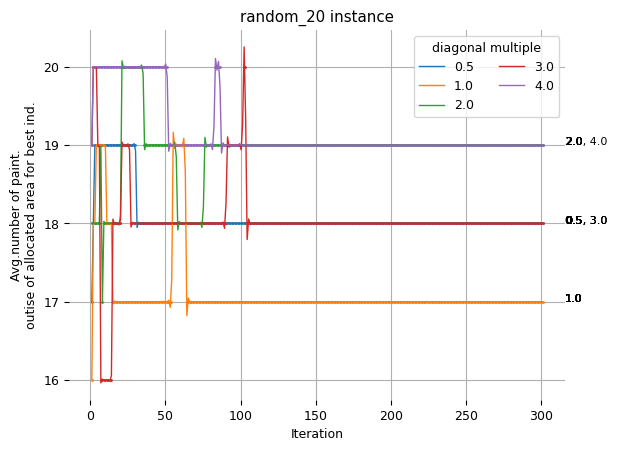

In [21]:
dfAllocatedTS = dfAllocated.groupby(['name', 'overlappingMult'])['overlapCnt'].mean()

for name in dfAllocated.name.unique():
    for constant in dfAllocated.overlappingMult.unique():
        label = f'{constant}'
        ts = dfAllocatedTS[name, constant]
        plotter(x=range(1, len(ts)+1), y=ts, label=label, title=f'{name} instance', legendTitle='diagonal multiple', scatterDotSize=1, ncol=2,
               fontsize=9, xlabel='Iteration', ylabel='Avg.number of paint.\noutise of allocated area for best ind.',
               annotateEndOfLines=True,annotateEndOfLinesPenalization=100)
    plt.savefig(f'figures2/outside_of_allocated_area_penalization_constant_{name}.pdf', bbox_inches='tight')
    plt.show()

# Graphs [deprecated]

## Flow matrix

Loading /home/slarty/Documents/master-thesis/src/impl/public/datasets/cluster/cluster_3_6.json


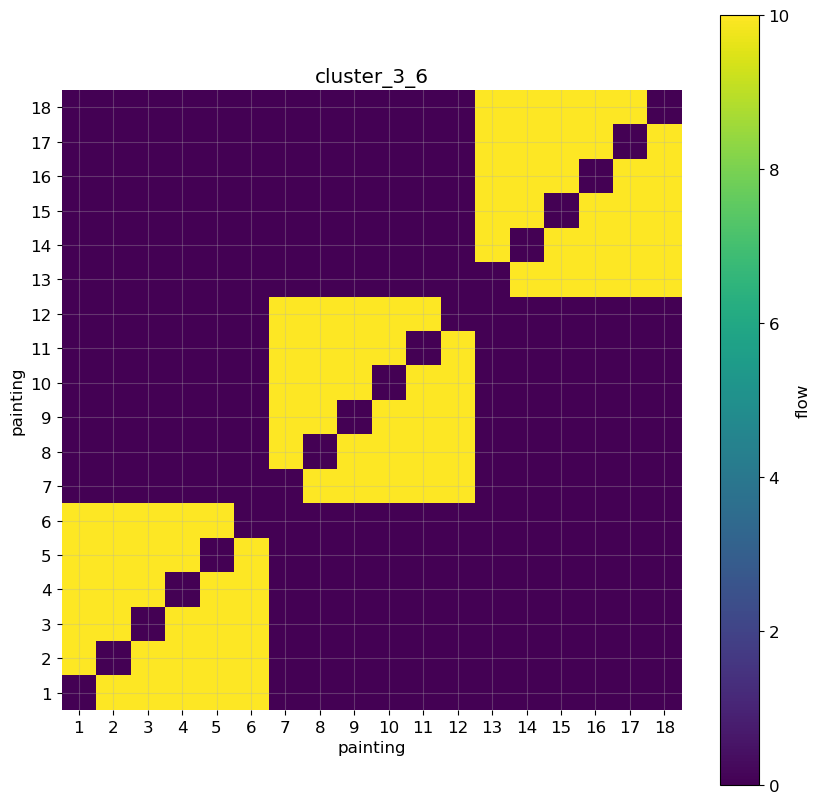

Loading /home/slarty/Documents/master-thesis/src/impl/public/datasets/random/random_10.json


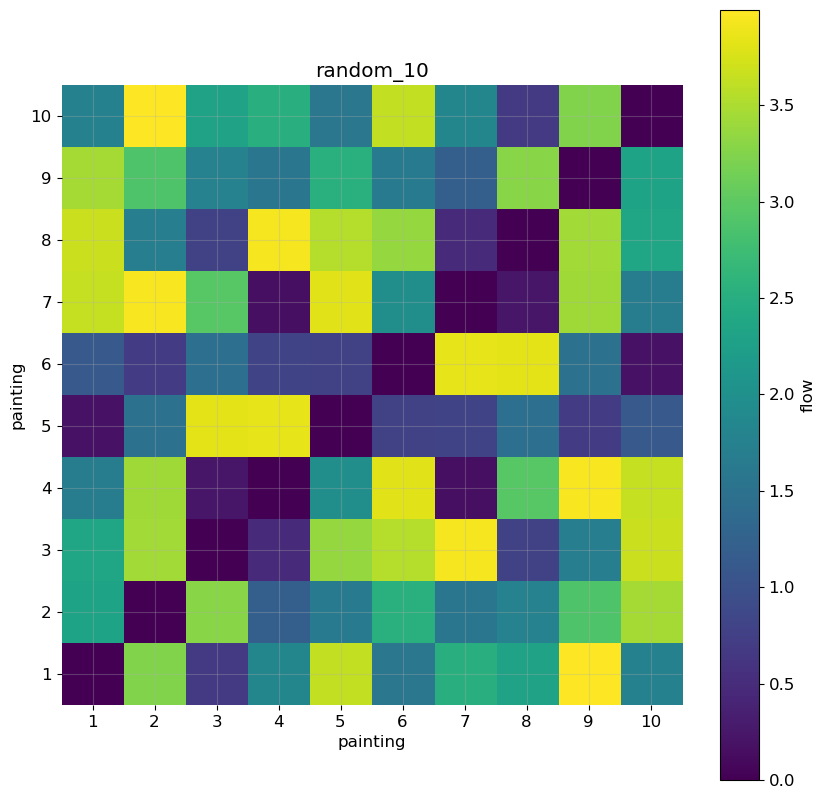

Loading /home/slarty/Documents/master-thesis/src/impl/public/datasets/random/random_20.json


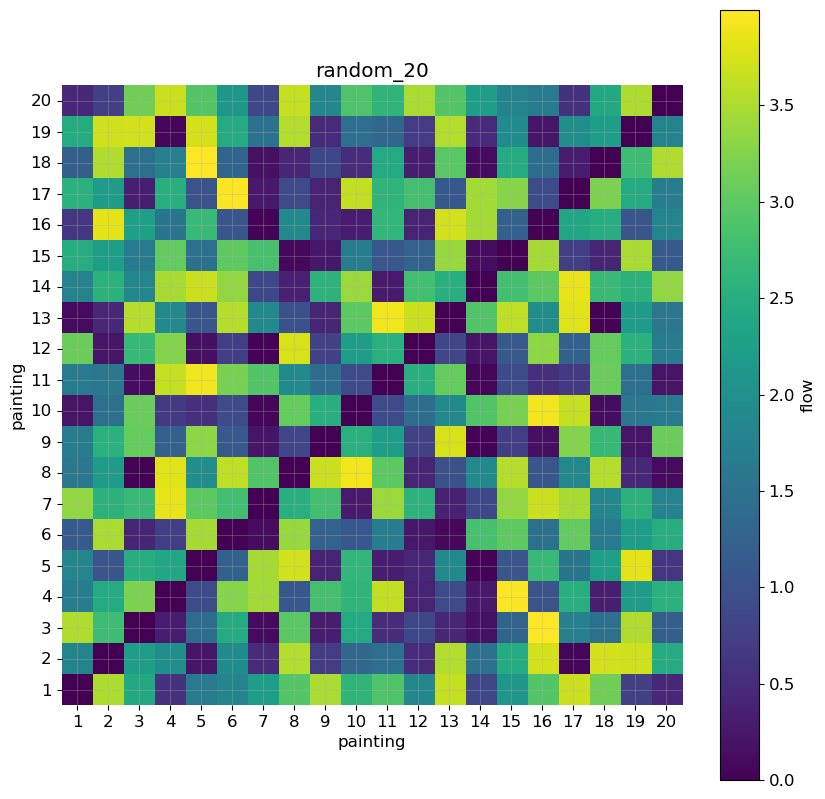

Loading /home/slarty/Documents/master-thesis/src/impl/public/datasets/packing/packing_10.json


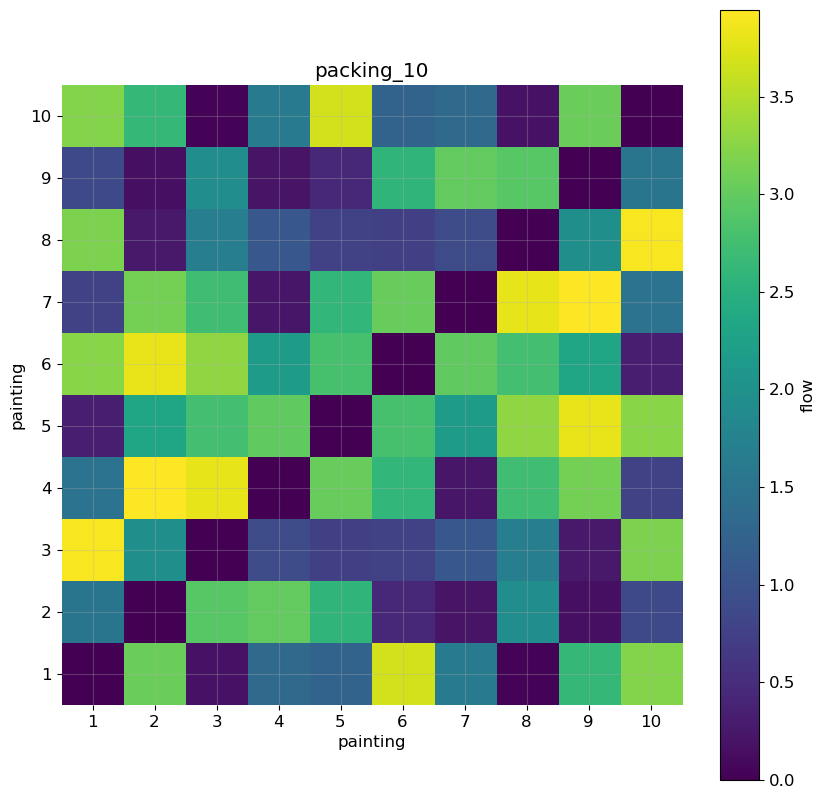

Loading /home/slarty/Documents/master-thesis/src/impl/public/datasets/packing/packing_20.json


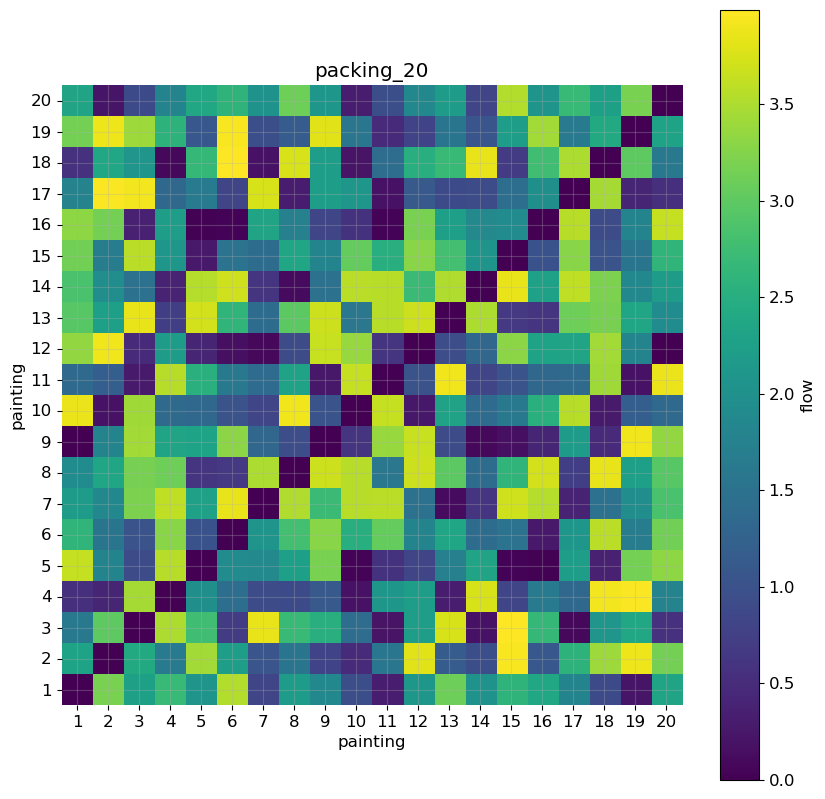

Loading /home/slarty/Documents/master-thesis/src/impl/public/datasets/cluster/cluster_3_10.json


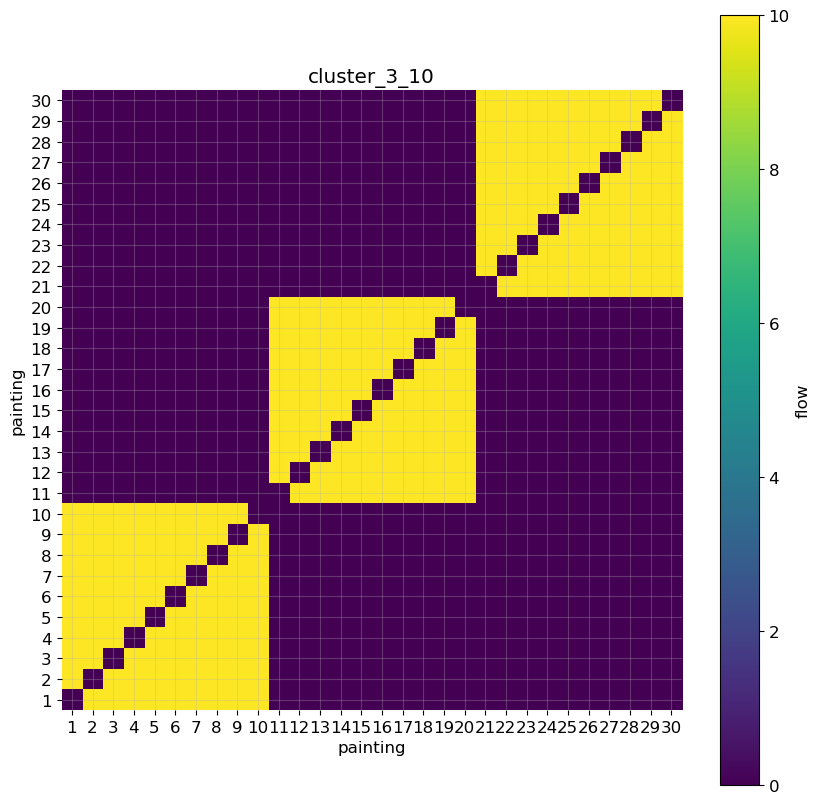

Loading /home/slarty/Documents/master-thesis/src/impl/public/datasets/cluster/cluster_4_20.json


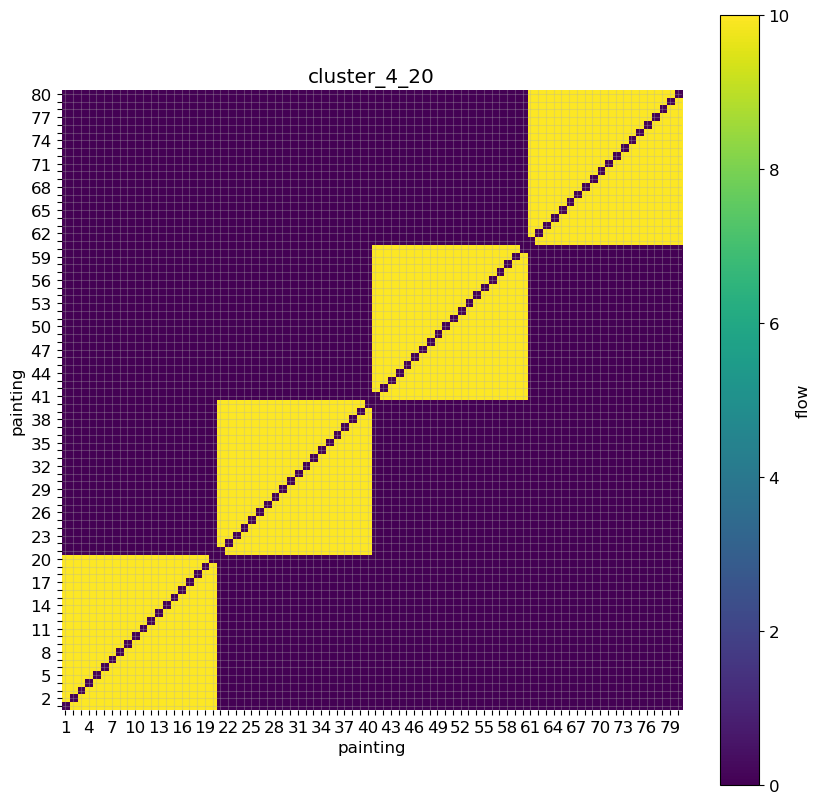

Loading /home/slarty/Documents/master-thesis/src/impl/public/datasets/biased_sparse_cluster/biased_sparse_cluster_3_10.json


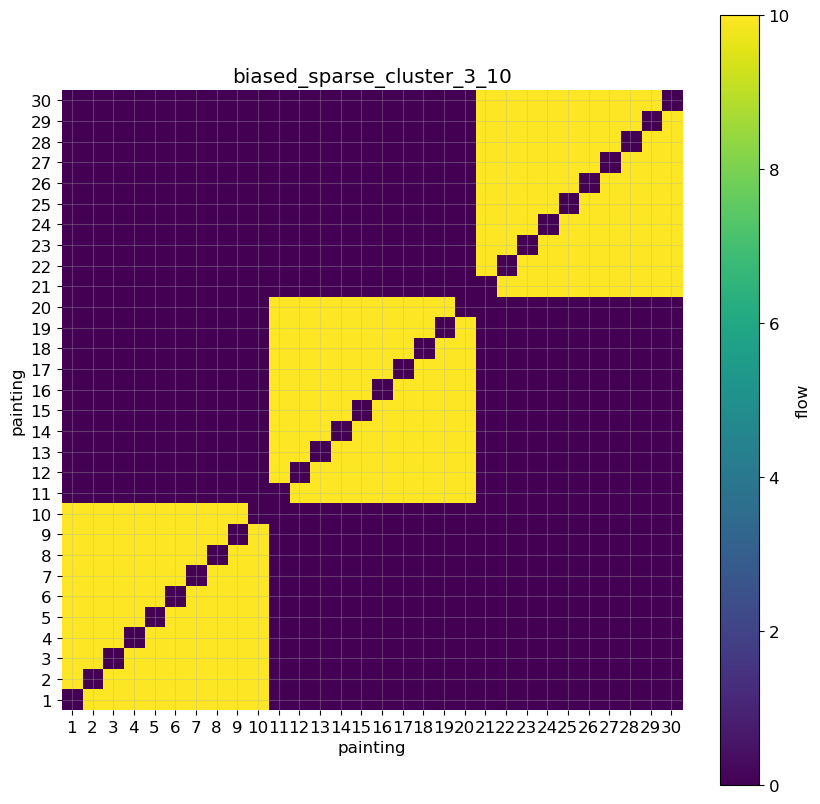

In [13]:
plt.rcParams.update({'font.size': 12})

for name, size in [('cluster_3_6', 18), ('random_10', 10), ('random_20', 20), ('packing_10', 10), ('packing_20', 20), ('cluster_3_10', 30), ('cluster_4_20', 80),
                  ('biased_sparse_cluster_3_10', 30)]:
    dataset = loadDataset(name)
    flows = np.zeros((size,size), dtype=float)
    for f in dataset.data.paintingsFlow:
        x,y = size-f.src, f.dst-1
        flows[x,y] = f.flow
        flows[size-x-1, size-y-1] = f.flow
        
    # A = flows
    # mask = np.rot90(np.tri(flows.shape[0], k=-1), k=3)
    # A = np.ma.array(A, mask=mask) # mask out the lower triangle
    # cmap = CM.get_cmap('viridis', size) # jet doesn't have white color
    # cmap.set_bad('w') # default value is 'k'
    # print(flows)
    A = flows
    # print(A)
    
    fig = plt.figure(figsize=(10, 10))
    plt.xlabel('painting')
    plt.ylabel('painting')
    xticks = list(range(0,size)), list(range(1,size+1))
    yticks = list(range(0,size)), list(range(size, 0, -1))
    if size > 40:
        for i in range(0, len(xticks[1])):
            if i % 3 != 0:
                xticks[1][i] = ''
                yticks[1][i] = ''
        
    plt.xticks(*xticks)
    plt.yticks(*yticks)
    plt.imshow(A, interpolation='nearest')#, cmap=cmap)
    plt.title(name)
    plt.grid(True, alpha=0.3)
    cbar = plt.colorbar()
    cbar.set_label('flow')
    plt.savefig(f"figures/heatmap_{name}.pdf")
    plt.show()

## Population size X average objective

In [54]:
r = loadComputationResultBatch('./out/population_size', addName=True, addInstanceSize=True)
df = compResToDf(r)
df['N'] = (df.populationSize / df['size']).astype('int32')

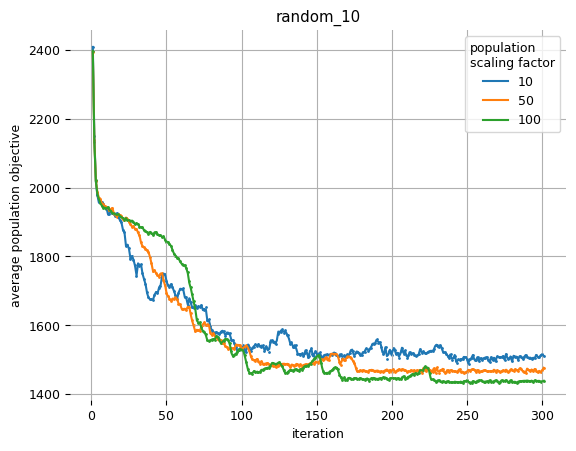

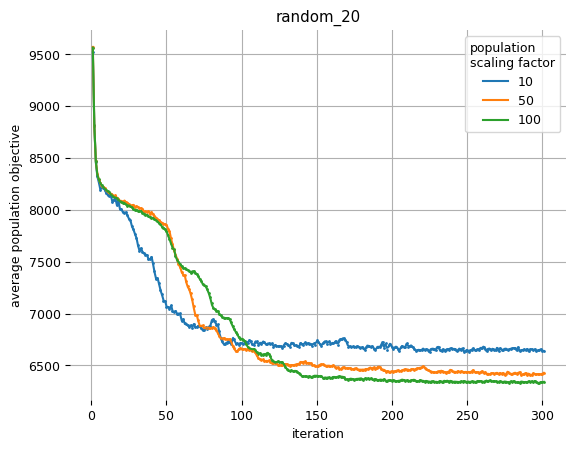

In [6]:
turnSpinesOff()
plt.rcParams.update({'font.size': 9})
dfTS = df.groupby([df.name, df.N])['avgObjTS'].mean()

for name in ['random_10', 'random_20']:
    for N in [10, 50, 100]:
        label = f'{N}'
        ts = dfTS[name, N]
        plotter(x=range(1, len(ts)+1), y=ts, label=label, title=name, legendTitle='population\nscaling factor', scatterDotSize=1,
               fontsize=9, xlabel='iteration', ylabel='average population objective')
    plt.savefig(f'figures/pop_size_{name}.pdf')
    plt.show()

## Overlapping Penalization Constant

In [131]:
def getOverlapCount(recLst: List[Rectangle]) -> int:
    cnt = 0
    for i in range(len(recLst)):
        for j in range(i+1, len(recLst)):
            if recLst[i].checkOverlap(recLst[j]):
                cnt += 1
    return cnt


rOverlap = loadComputationResultBatch('./out/overlapping_penalization_constant', addName=True, addInstanceSize=True)
dfOverlap = compResToDf(rOverlap)
dfOverlap['N'] = (dfOverlap.populationSize / dfOverlap['size']).astype('int32')
dfOverlap['overlapCnt'] = dfOverlap.paintingPlacement.apply(lambda xx: np.array([getOverlapCount(x) for x in xx]))
dfOverlap['overlappingMult'] =  (dfOverlap.overlappingPenalizationConstant / np.sqrt(dfOverlap.width**2+dfOverlap.height**2)).astype('int32')

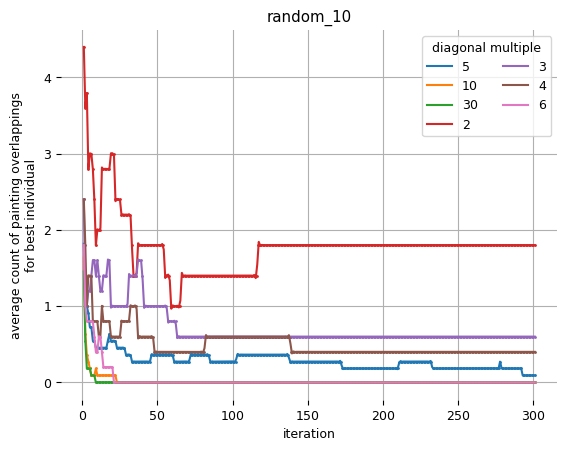

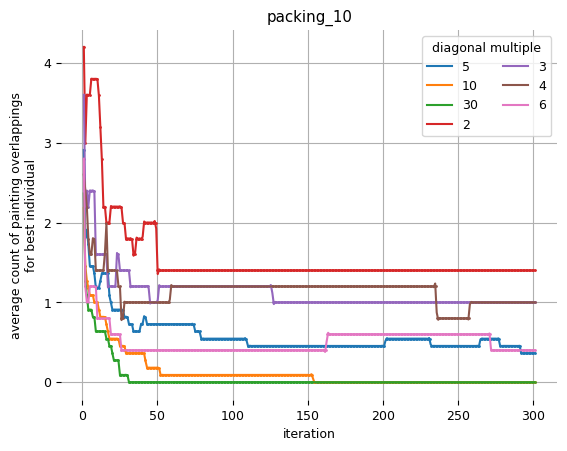

In [136]:
turnSpinesOff()
plt.rcParams.update({'font.size': 9})
# dfOverlap = dfOverlap[dfOverlap.overlappingMult > 1]
dfOverlapTS = dfOverlap.groupby(['name', 'overlappingMult'])['overlapCnt'].mean()

for name in dfOverlap.name.unique():
    for constant in dfOverlap[dfOverlap.name == name].overlappingMult.unique():
        label = f'{constant}'
        ts = dfOverlapTS[name, constant]
        plotter(x=range(1, len(ts)+1), y=ts, label=label, title=name, legendTitle='diagonal multiple', scatterDotSize=1, ncol=2,
               fontsize=9, xlabel='iteration', ylabel='average count of painting overlappings\nfor best individual')
    plt.savefig(f'figures/overlapping_penalization_constant_{name}.pdf')
    plt.show()

## Cluster

In [7]:
rC = loadComputationResultBatch('./out/cluster', addName=True, addInstanceSize=True)
dfC = compResToDf(rC)
dfC['N'] = (dfC.populationSize / dfC['size']).astype('int32')

### average population objective X wild card count 0/1

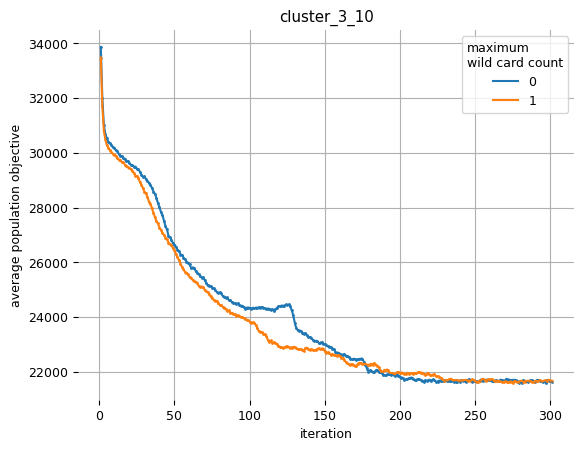

In [8]:
turnSpinesOff()
plt.rcParams.update({'font.size': 9})
dfCTS = dfC.groupby([dfC.name, dfC.maximumWildCardCount])['avgObjTS'].mean()

for name in ['cluster_3_10']:
    for maximumWildCardCount in [0,1]:
        label = f'{maximumWildCardCount}'
        ts = dfCTS[name, maximumWildCardCount]
        plotter(x=range(1, len(ts)+1), y=ts, label=label, title=name, legendTitle='maximum\nwild card count', scatterDotSize=1,
               fontsize=9, xlabel='iteration', ylabel='average population objective')
    plt.savefig(f'figures/{name}.pdf')
    plt.show()

## Maximum wild card count

In [9]:
rW = loadComputationResultBatch('./out/wild_card_comp_time', addName=True, addInstanceSize=True)
dfW = compResToDf(rW)
dfW['N'] = (dfW.populationSize / dfW['size']).astype('int32')
dfW['durationSeconds'] = dfW.durationMillis / 1000
dfW['durationMinutes'] = dfW.durationSeconds / 60

### Computation time

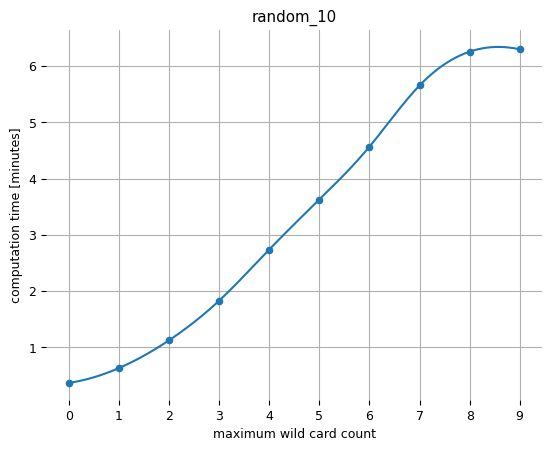

In [128]:
turnSpinesOff()
plt.rcParams.update({'font.size': 9})
dfWTS = dfW.groupby([dfW.name, dfW.maximumWildCardCount])['durationMinutes'].mean()

for name in ['random_10']:
    tmp = dfWTS[name].reset_index()[['maximumWildCardCount', 'durationMinutes']]
    x = tmp['maximumWildCardCount'].tolist()
    y = tmp['durationMinutes'].tolist()
    label = f'label'
    plotter(x=x, y=y, label=label, title=name, legendTitle='', scatterDotSize=20,
           fontsize=9, xlabel='maximum wild card count', ylabel='computation time [minutes]', ncol=1)
    plt.savefig(f'figures/computation_time_{name}.pdf')
    plt.xticks(x)
    plt.show()

### Objective